In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import math

import torch
from torch.nn import functional as F
import pytorch_lightning as pl
from torchvision.datasets import MNIST
from torchmetrics import Accuracy
from torchvision.transforms import ToTensor
from torch import utils
from torch import nn
from torchmore import flex, layers

def image_grid(array, ncols=4):
    index, height, width, channels = array.shape
    nrows = index//ncols
    
    img_grid = (array.reshape(nrows, ncols, height, width, channels)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols))
    
    return img_grid
# from pl_bolts.datamodules.mnist_datamodule import MNISTDataModule


In [3]:
def transform(im):
    a = ToTensor()(im)
    assert a.shape == (1, 28, 28), a.shape
    return a

    
batch_size = 256

train_ds = list(MNIST(os.getcwd(), download=True, transform=transform))
train_loader = utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
test_ds = list(MNIST(os.getcwd(), download=True, transform=transform, train=False))
test_loader = utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=0)
images = [x[0] for x in train_ds]

In [4]:
class LightningClassifier(pl.LightningModule):
    def __init__(self, network, config):
        super(LightningClassifier, self).__init__()
        self.network = network
        self.lr = config.get("lr", 0.1)
        self.optim = getattr(torch.optim, config.get("optim", "SGD"))
        self.accuracy = Accuracy()

    def forward(self, x):
        y = self.network(x)
        return torch.log_softmax(y, dim=1)

    def configure_optimizers(self):
        return self.optim(self.network.parameters(), lr=self.lr)

    def training_step(self, train_batch, batch_idx, prefix=""):
        x, y = train_batch
        # assert x.shape[1] == 1, x.shape
        logits = self.forward(x)
        closs = F.cross_entropy(logits, y)
        pvec = F.softmax(logits, dim=1).sum(0)
        pvec = pvec / pvec.sum()
        ploss = ((pvec - 1.0 / len(pvec))**2).sum()
        loss = closs + 500.0 * ploss
        acc = self.accuracy(logits, y)
        self.log(prefix + "loss", loss)
        self.log(prefix + "ploss", ploss)
        self.log(prefix + "closs", closs)
        self.log(prefix + "acc", acc)
        return loss

    def validation_step(self, batch, batch_idx):
        return self.training_step(batch, batch_idx, prefix="val_")

In [5]:
nclasses = 100
network = nn.Sequential(
    nn.Flatten(), 
    flex.Linear(100), nn.Sigmoid(),
    flex.Linear(nclasses),
)

flex.shape_inference(network, (4, 1, 28, 28))
xs, ys = next(iter(train_loader))
print(xs.shape, network(xs).shape)

torch.Size([256, 1, 28, 28]) torch.Size([256, 100])


In [6]:
def reassign(c, deltas):
    if deltas[c] <= 0:
        return int(c)
    choices = np.where(deltas < 0)[0]
    if len(choices) == 0:
        return int(c)
    to = np.random.choice(choices)
    deltas[c] -= 1
    deltas[to] += 1
    return int(to)

In [7]:
from random import randrange
fakeds = [(image, randrange(0, nclasses)) for image in images]

def reassign_ds(ds, excess=1.5):
    classes = [x[1] for x in ds]
    threshold = excess * len(classes) / nclasses
    deltas = np.bincount(classes, minlength=nclasses) - threshold
    print("deltas", deltas)
    result = [(x[0], reassign(x[1], deltas)) for x in ds]
    changed = np.sum(np.array([x[1] for x in result]) != np.array([x[1] for x in ds]))
    print("changed", changed)
    return result

In [16]:
from random import randrange
fakeds = [(image, randrange(0, nclasses)) for image in images]
config={"lr": 0.8}
model = LightningClassifier(network, config)

for round in range(10):
    fakeds = reassign_ds(fakeds)
    print("*** Round", round)
    loader = utils.data.DataLoader(fakeds, batch_size=batch_size, shuffle=True, num_workers=0)
    xs, ys = next(iter(loader))
    print(xs.shape, network(xs).shape)
    trainer = pl.Trainer(max_epochs=5)
    trainer.fit(model=model, train_dataloaders=loader)
    trainer.validate(model=model, dataloaders=loader)
    newds = []
    loader = utils.data.DataLoader(fakeds, batch_size=batch_size, shuffle=True, num_workers=0)
    for xs, _ in loader:
        pred = model.network(xs).argmax(dim=1) 
        for x, p in zip(xs, pred):
            newds.append((x, p))

deltas [-0.09 -0.09 -0.09 -0.09 -0.09  0.91 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09
 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09
 -0.09 -0.09  0.91  0.91 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09
 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09
 -0.09 -0.09 -0.09  0.91 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09
 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09  0.91 -0.09 -0.09
 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09  0.91 -0.09 -0.09
 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09
 -0.09 -0.09 -0.09 -0.09]
changed 6
*** Round 0
torch.Size([6, 28, 28, 1]) torch.Size([6, 100])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type       | Params
----------------------------------------
0 | network  | Sequential | 88.6 K
1 | accuracy | Accuracy   | 0     
----------------------------------------
88.6 K    Trainable params
0         Non-trainable params
88.6 K    Total params
0.354     Total estimated model params size (MB)
/home/tmb/tutorials/dl-2022/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.1666666716337204
        val_closs            5.242298603057861
        val_loss             5.312229633331299
        val_ploss         0.00013986242993269116
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
deltas [-0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09
 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09  0.91 -0.09
 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09
  0.91 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09
 -0.09  0.91 -0.09 -0.09 -0.09  0.91 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09
 -0.09 -0.09 -0.09 -0.09 -0.09 

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type       | Params
----------------------------------------
0 | network  | Sequential | 88.6 K
1 | accuracy | Accuracy   | 0     
----------------------------------------
88.6 K    Trainable params
0         Non-trainable params
88.6 K    Total params
0.354     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.3333333432674408
        val_closs            4.082369327545166
        val_loss             4.261728763580322
        val_ploss         0.00035871900035999715
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
deltas [-0.09 -0.09 -0.09 -0.09 -0.09 -0.09  0.91 -0.09 -0.09 -0.09 -0.09 -0.09
 -0.09 -0.09 -0.09 -0.09  0.91 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09
 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09
 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09
 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09
 -0.09  0.91 -0.09 -0.09 -0.09 

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type       | Params
----------------------------------------
0 | network  | Sequential | 88.6 K
1 | accuracy | Accuracy   | 0     
----------------------------------------
88.6 K    Trainable params
0         Non-trainable params
88.6 K    Total params
0.354     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.3333333432674408
        val_closs            4.100127696990967
        val_loss             4.276227951049805
        val_ploss         0.00035220023710280657
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
deltas [-0.09  0.91 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09
 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09
 -0.09 -0.09 -0.09  0.91 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09
 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09
  0.91 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09
 -0.09 -0.09 -0.09 -0.09 -0.09 

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type       | Params
----------------------------------------
0 | network  | Sequential | 88.6 K
1 | accuracy | Accuracy   | 0     
----------------------------------------
88.6 K    Trainable params
0         Non-trainable params
88.6 K    Total params
0.354     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.1666666716337204
        val_closs            4.087677478790283
        val_loss             4.264798164367676
        val_ploss         0.00035424125962890685
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
deltas [-0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09
 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09
 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09  0.91 -0.09 -0.09 -0.09 -0.09
 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09  0.91 -0.09 -0.09
 -0.09  0.91 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09
 -0.09  0.91 -0.09 -0.09 -0.09 

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type       | Params
----------------------------------------
0 | network  | Sequential | 88.6 K
1 | accuracy | Accuracy   | 0     
----------------------------------------
88.6 K    Trainable params
0         Non-trainable params
88.6 K    Total params
0.354     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.1666666716337204
        val_closs           4.1095991134643555
        val_loss             4.270750999450684
        val_ploss          0.0003223042003810406
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
deltas [-0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09
 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09  0.91 -0.09 -0.09 -0.09 -0.09
 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09
 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09
 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09
 -0.09 -0.09 -0.09  0.91 -0.09 

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type       | Params
----------------------------------------
0 | network  | Sequential | 88.6 K
1 | accuracy | Accuracy   | 0     
----------------------------------------
88.6 K    Trainable params
0         Non-trainable params
88.6 K    Total params
0.354     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.3333333432674408
        val_closs            4.090214252471924
        val_loss             4.256727695465088
        val_ploss         0.00033302666270174086
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
deltas [-0.09 -0.09 -0.09  0.91 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09
 -0.09 -0.09 -0.09 -0.09 -0.09  0.91 -0.09  0.91 -0.09  0.91 -0.09 -0.09
 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09
 -0.09 -0.09 -0.09  0.91 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09
 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09
 -0.09 -0.09 -0.09 -0.09 -0.09 

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type       | Params
----------------------------------------
0 | network  | Sequential | 88.6 K
1 | accuracy | Accuracy   | 0     
----------------------------------------
88.6 K    Trainable params
0         Non-trainable params
88.6 K    Total params
0.354     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.3333333432674408
        val_closs           4.1113457679748535
        val_loss             4.246022701263428
        val_ploss         0.00026935359346680343
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
deltas [-0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09
 -0.09  0.91 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09  0.91  0.91
 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09
 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09  0.91 -0.09 -0.09 -0.09 -0.09
 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09
 -0.09 -0.09 -0.09 -0.09 -0.09 

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type       | Params
----------------------------------------
0 | network  | Sequential | 88.6 K
1 | accuracy | Accuracy   | 0     
----------------------------------------
88.6 K    Trainable params
0         Non-trainable params
88.6 K    Total params
0.354     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.1666666716337204
        val_closs            4.134180545806885
        val_loss             4.283152103424072
        val_ploss          0.0002979430428240448
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
deltas [-0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09  0.91
 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09  0.91 -0.09
 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09
 -0.09 -0.09 -0.09 -0.09  0.91 -0.09 -0.09 -0.09 -0.09 -0.09  0.91 -0.09
 -0.09  0.91 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09
 -0.09 -0.09 -0.09 -0.09 -0.09 

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type       | Params
----------------------------------------
0 | network  | Sequential | 88.6 K
1 | accuracy | Accuracy   | 0     
----------------------------------------
88.6 K    Trainable params
0         Non-trainable params
88.6 K    Total params
0.354     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.3333333432674408
        val_closs            4.093245983123779
        val_loss             4.248083114624023
        val_ploss          0.0003096739819739014
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
deltas [-0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09  0.91 -0.09 -0.09  0.91
 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09  0.91 -0.09 -0.09 -0.09
 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09  0.91 -0.09 -0.09 -0.09 -0.09 -0.09
 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09
 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09
 -0.09 -0.09 -0.09 -0.09 -0.09 

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type       | Params
----------------------------------------
0 | network  | Sequential | 88.6 K
1 | accuracy | Accuracy   | 0     
----------------------------------------
88.6 K    Trainable params
0         Non-trainable params
88.6 K    Total params
0.354     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.3333333432674408
        val_closs            4.11632776260376
        val_loss             4.246031284332275
        val_ploss         0.00025940738851204515
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


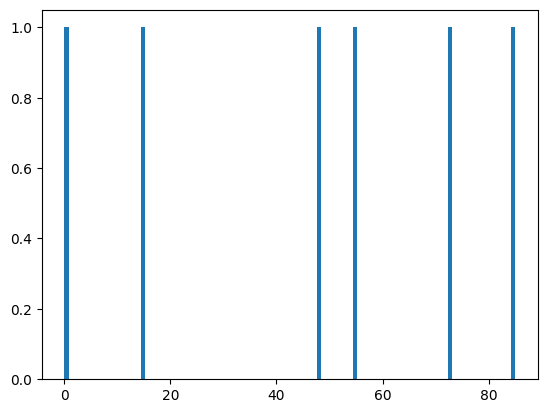

In [17]:
hist([int(y) for _, y in fakeds], bins=nclasses);

In [18]:
clusters = [[] for _ in range(nclasses)]
for i, (x, y) in enumerate(fakeds):
    clusters[y].append(x[0].numpy())

centers = [np.mean(x, axis=0) for x in clusters]
    
order = np.argsort([len(x) for x in clusters])[::-1]

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [19]:
nr=10
nc=6
for c in order[:10]:
    images = np.array(clusters[c])[:nc]
    if len(images) < nc:
        continue
    images = images.reshape(nc, 28, 28, 1)
    result = image_grid(images, ncols=nc)
    fig = plt.figure(figsize=(8, 8))
    plt.imshow(result)